<a href="https://colab.research.google.com/github/sebastianJamesMI/Fellowship_AI_IMDB/blob/main/Sentiment_Analysis_IMDB_TF_Tokenizer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project uses the IMDB dataset compiled by Andrew Maas (see http://a
i.stanford.edu/~amaas/data/sentiment/).

- The objective is to classify movie reviews as positive or negative. The original reviews were rated on a scale from 1 to 10. For Binary Classification, anything with <= 4 was classfed as negative and anything with >= 7 stars were classified as positive. 



I use different strategies to perform this classification task starting with a simple RNN model (LSTM) then using more complex models. This notebook uses a simple Baseline model and references the following sources:
1. Data reading and downloading, Aaron Kub: 
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
2. Data Reading and Downloading: Georgios Drakos: https://gdcoder.com/sentiment-clas/
2. Word Tokenization: Coursera Deep learning NLP courses by Andrew Ng


Download the data from http://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
## Actual Analysis
import numpy as np
import pandas as pd
from glob import glob
import os
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## Read in train and test files, we can use these filesn for future notebooks
train_df = pd.read_csv('/content/drive/MyDrive/Projects/FellowshipAI/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Projects/FellowshipAI/test.csv')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(25000, 2)
(25000, 2)


In [ ]:
## An example of training data
print('The review text is: {}'.format(train_df['text'][0]))
print('\n')
print(f"The label is: {train_df['label'][0]}")

The review text is: BRIEF ENCOUNTER is a ghastly and pointless remake of the 1945 David Lean classic, which was based on Noel Coward's play "Still Life". A doctor removes a particle of grit from a woman's eye at a railway station, he is in a miserable relationship, she is happily married social worker of Italian ancestry. They meet by accident on another occasion, form an instant attraction and arrange to meet each other every Wednesday. The pair fall in love, but after spending a few afternoons together they realise that they have no realistic chance of happiness and agree to part. Coward's original one-act play concerned two ordinary people who fall in love. Sophia Loren and Richard Burton, two Super Stars and veterans of Hollywood Epics, are nobody's idea of 'ordinary people'. Loren in particular is miscast - Sophia Loren in full make-up, looking like a million dollars, working as a part-time voluntary social worker at a Citizen Advice Bureau just doesn't ring true. Burton, looking 

In [ ]:
## split the training data further into trian and validation
train, val = train_test_split(train_df, test_size=0.2)
test = test_df

In [ ]:
val.head()

,text,label
1481,A woman (Sylvia Kristel) seduces a 15 year old...,0
9911,Let this serve as a warning to anyone wishing ...,0
5842,"I just saw this movie, and I have to say that ...",0
6815,"This film is so incredibly bad, that I almost ...",0
415,"Well, what can it be said about this disaster?...",0


In [ ]:
val['text'].iloc[0]

"A woman (Sylvia Kristel) seduces a 15 year old boy (Eric Brown). They have sex...but it's all tied into some stupid plot or something.<br /><br />Easily one of the most disturbing sex comedies ever. Does anyone realize this movie is making light of child molestation? I suppose it's OK cause it's a teenage boy--if we had one with a man seducing a teenage girl there would (rightfully) be outrage. Sorry, but having it done to a boy doesn't excuse it. It's still sick. I realize Brown was of age (he was actually 18 when this was made) but he LOOKS 15. I just find it disturbing that some people find this OK.<br /><br />Plot aside the acting sucks (Kristel is beautiful--but can't act; Brown is easily one of the worst child actors I've ever seen) and the constant nudity gets boring and isn't even remotely erotic.<br /><br />I saw this drivel at a theatre back in 1981. I was 19 and with my 14 year old cousin (who could easily pass for 18). HE wanted to see it--I didn't but I decideD what the h

In [ ]:
## This model is a Baseline Using an LSTM

In [ ]:
## Text data needs to be converted to numerical data using tokenizing
oov_tok = "<OOV>"

In [ ]:
# we use tensorflow tokenizer which will do some preprocessing
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train['text'])
word_index = tokenizer.word_index  ## this is the dictionary storing word: token pairs

In [ ]:
vocab_size = len(word_index)
embedding_dim = 64
max_length = 240
trunc_type='post'

In [ ]:
#converting text to number (token) sequences and padding, the inputs need to be of same dimension
train_sequences = tokenizer.texts_to_sequences(train['text'])
train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating=trunc_type, padding='post')

val_sequences = tokenizer.texts_to_sequences(val['text'])
val_padded = pad_sequences(val_sequences,maxlen=max_length, truncating=trunc_type, padding='post')

test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences,maxlen=max_length, truncating=trunc_type, padding='post')

In [ ]:
print(train_sequences[0])
print(train_padded[0])

[46, 12, 7, 419, 6, 27, 2, 324, 577, 385, 70, 44, 31, 339, 2, 1007, 40, 143, 1288, 8, 8, 4, 24633, 431, 29, 248, 1100, 239, 183, 11006, 1095, 32, 3, 37, 93, 21, 43, 30, 182, 2167, 16, 88, 5288, 16305, 2, 29, 3278, 1692, 9, 12, 20, 299, 25, 117, 8163, 1677, 457, 451, 39, 2527, 31, 87, 25, 110, 45, 688, 32, 2, 657, 5, 2, 430, 56, 64, 1074, 6, 1722, 12, 56, 2047, 25, 364, 6, 212, 9, 3, 1082, 43, 30, 206, 6, 356, 2, 5028, 15, 192, 15, 43, 22, 9, 1007, 5, 2, 476, 8, 8, 12, 7, 4, 618, 1109, 5, 6012, 2686, 2105, 4052, 23, 711, 119, 12, 20, 14, 5428, 8, 8, 11, 1247, 1523, 44, 1326, 52, 31, 2, 127, 52, 16305, 7, 6945, 39, 6013, 635, 16, 7560, 56, 1655, 13, 135, 25, 110, 67, 77, 593, 350, 31, 548, 3257, 28, 67, 409, 4, 130, 49, 130, 28, 67, 77, 4, 6286, 1688, 1032, 2, 89, 2613, 4052, 231, 17, 1781, 11343, 3, 15474, 916, 13, 136, 9, 2, 10676, 119, 28, 691, 4, 1678, 13, 15, 4, 31182, 3388, 28, 83, 5918, 51, 73, 2, 1678, 7, 4, 404, 463, 5, 49, 268, 21, 9, 260, 5694, 2, 587, 3, 2183, 579, 5, 1121, 1

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(val_padded[0]))
print(val['text'].iloc[0])

a woman sylvia kristel seduces a 15 year old boy eric brown they have sex but it's all tied into some stupid plot or something br br easily one of the most disturbing sex comedies ever does anyone realize this movie is making light of child molestation i suppose it's ok cause it's a teenage boy if we had one with a man seducing a teenage girl there would rightfully be outrage sorry but having it done to a boy doesn't excuse it it's still sick i realize brown was of age he was actually 18 when this was made but he looks 15 i just find it disturbing that some people find this ok br br plot aside the acting sucks kristel is beautiful but can't act brown is easily one of the worst child actors i've ever seen and the constant nudity gets boring and isn't even remotely erotic br br i saw this drivel at a theatre back in 1981 i was 19 and with my 14 year old cousin who could easily pass for 18 he wanted to see it i didn't but i decided what the heck we got in and i actually bought tickets for

In [ ]:
# set model parameters here
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
#convert to tf.Data
def get_df(padded, labels):
    tempx = padded
    tempy = labels
    
    datasetx = tf.data.Dataset.from_tensor_slices(tempx)
    datasety = tf.data.Dataset.from_tensor_slices(tempy)
      
    datasets = tf.data.Dataset.zip((datasetx, datasety))
 
    return datasets

In [ ]:
train_ds = get_df(train_padded, train['label'])
val_ds = get_df(val_padded, val['label'])
test_ds = get_df(test_padded, test['label'])

In [ ]:
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 240), dtype=tf.int32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
for x, y in train_ds.take(1):
    print(f'The text for this example is: \n {x[0]}')
    print(f'The label for this example is: \n {y[0]}')

The text for this example is: 
 [    2  6812     7    33   791     6    94     4  1005  6451  6322   557
     5    63    17    33  6320     3     4  7698   254    10   185     6
   212    31    10    32    96     5   364    40  5058  3141 12263     2
   103    24  2029     3  3100    15    24     2   802     3   112   343
     2    18   185  2991   202  5908     3  1134    21     2    29   512
    47     7     4  3175   791    31   109  2029    15     9    29   463
     5   108    48  1410   103    57   925  1204    13  6992   912     5
  2604    78     2  4297    31   512     3    75  2716    38  1416  1059
   131     6    94     4  3643    16     4  5685   436     2 10504    90
    75   960   720     2   570  5183     5   137     4   343    43    41
    29     5   108  4726 10399 10929    13     2    18     7    41    15
  4061     3 27899    15    92   426  3291    21     2    80   512     2
  1324   287 10574     6  1134  1156     2  1810     6     4  2932     5
  5769     4   296 

In [ ]:
#set callbacks: Early Stopping and Reduce Learning Rate
def get_callbacks():
    """
    This function should create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    The callbacks should be instantiated according to the above requirements.
    """
    early_stopping = EarlyStopping(patience = 5, mode = 'min')
    learning_rate_reduction = ReduceLROnPlateau(factor=0.2, patience =3)
    return (early_stopping,learning_rate_reduction)

early_stopping, learning_rate_reduction = get_callbacks()
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Projects/FellowshipAIweights.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')

In [ ]:
#Define model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, mask_zero = True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation = 'sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 240, 64)           5140160   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 5,214,529
Trainable params: 5,214,529
Non-trainable params: 0
_________________________________________________________________


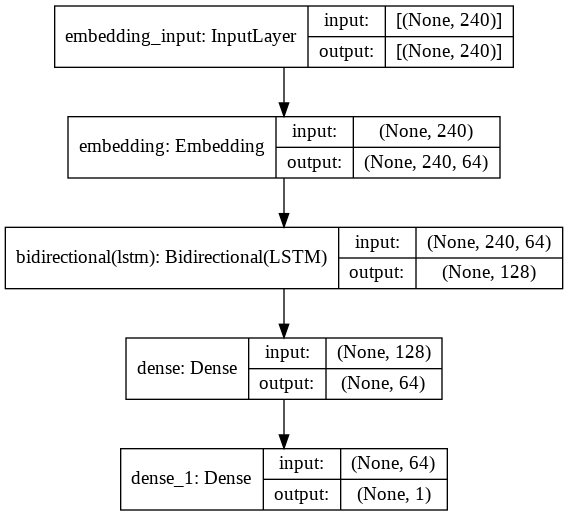

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
num_epochs = 30
history = model.fit(train_ds, validation_data = val_ds, epochs=num_epochs, shuffle = True, callbacks = [early_stopping,learning_rate_reduction, checkpoint])

Epoch 1/30
313/313 [==============================] - 68s 98ms/step - loss: 0.6831 - accuracy: 0.5540 - val_loss: 0.4418 - val_accuracy: 0.8184

Epoch 00001: val_loss improved from inf to 0.44185, saving model to /content/drive/MyDrive/Projects/FellowshipAIweights.h5
Epoch 2/30
313/313 [==============================] - 28s 89ms/step - loss: 0.3756 - accuracy: 0.8445 - val_loss: 0.3617 - val_accuracy: 0.8362

Epoch 00002: val_loss improved from 0.44185 to 0.36165, saving model to /content/drive/MyDrive/Projects/FellowshipAIweights.h5
Epoch 3/30
313/313 [==============================] - 27s 87ms/step - loss: 0.2408 - accuracy: 0.9086 - val_loss: 0.3447 - val_accuracy: 0.8686

Epoch 00003: val_loss improved from 0.36165 to 0.34469, saving model to /content/drive/MyDrive/Projects/FellowshipAIweights.h5
Epoch 4/30
313/313 [==============================] - 27s 86ms/step - loss: 0.1672 - accuracy: 0.9389 - val_loss: 0.3688 - val_accuracy: 0.8674

Epoch 00004: val_loss did not improve from 

In [ ]:
def plot_loss(history): ## plot the loss curves
    #Run this cell to plot the epoch vs accuracy graph

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 

    #Run this cell to plot the epoch vs loss graph
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 
    return None

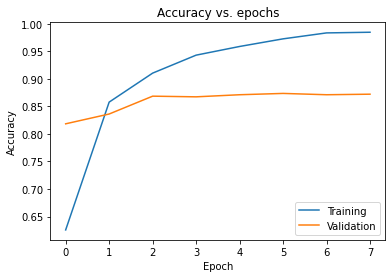

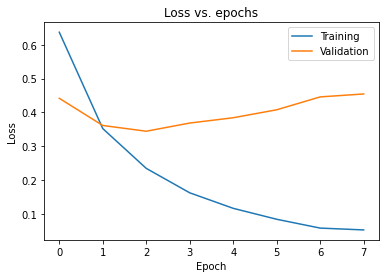

In [ ]:
plot_loss(history)

In [ ]:
def predict_test():
    ##Predict the test values
    ## loading best weights
    model.load_weights(f"/content/drive/MyDrive/Projects/FellowshipAIweights.h5")
    predicted_values = model.predict(test_ds)
    predicted_values = (predicted_values>0.5).astype('int32')
    accuracy = accuracy_score(test['label'], predicted_values)
    return accuracy

In [ ]:
###Accuracy for single layer LSTM
predict_test()

0.84688

In [ ]:
### stacking one or more LSTM layers

In [ ]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, mask_zero = True),
    Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
early_stopping, learning_rate_reduction = get_callbacks()
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Projects/FellowshipAIweights.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')

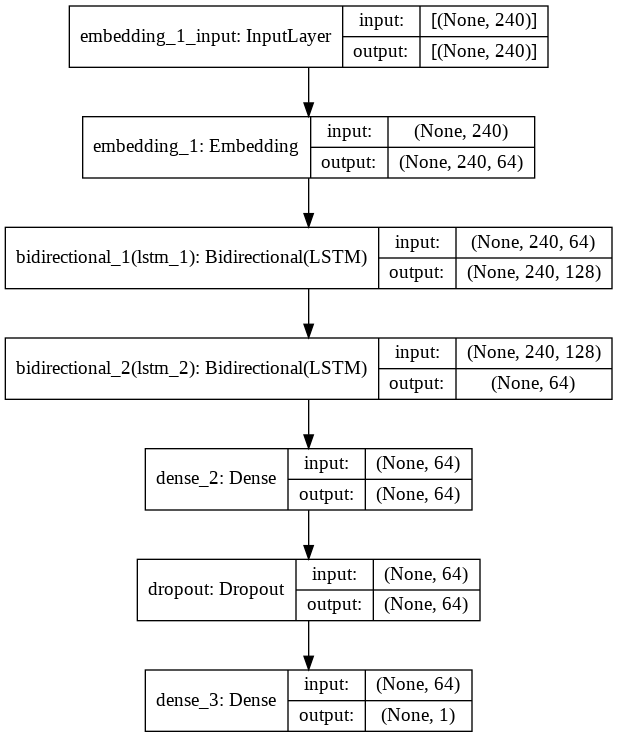

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(train_ds, epochs=10,
                    validation_data=val_ds,
                    validation_steps=30, callbacks = [early_stopping,learning_rate_reduction, checkpoint])

Epoch 1/10
313/313 [==============================] - 48s 116ms/step - loss: 0.6780 - accuracy: 0.5190 - val_loss: 0.4173 - val_accuracy: 0.8089

Epoch 00001: val_loss improved from inf to 0.41725, saving model to /content/drive/MyDrive/Projects/FellowshipAIweights.h5
Epoch 2/10
313/313 [==============================] - 32s 103ms/step - loss: 0.3315 - accuracy: 0.8666 - val_loss: 0.3392 - val_accuracy: 0.8708

Epoch 00002: val_loss improved from 0.41725 to 0.33923, saving model to /content/drive/MyDrive/Projects/FellowshipAIweights.h5
Epoch 3/10
313/313 [==============================] - 32s 103ms/step - loss: 0.1913 - accuracy: 0.9351 - val_loss: 0.3459 - val_accuracy: 0.8594

Epoch 00003: val_loss did not improve from 0.33923
Epoch 4/10
313/313 [==============================] - 32s 102ms/step - loss: 0.1094 - accuracy: 0.9667 - val_loss: 0.3752 - val_accuracy: 0.8724

Epoch 00004: val_loss did not improve from 0.33923
Epoch 5/10
313/313 [==============================] - 32s 101ms/

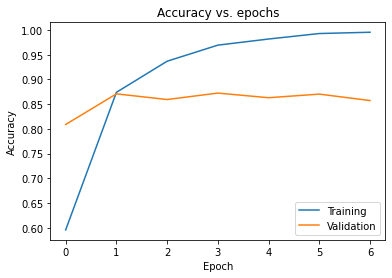

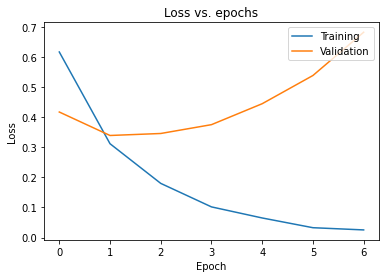

In [ ]:
plot_loss(history)

In [ ]:
predict_test()

0.8514